<div align="center">
  <img src="https://blogs.sas.com/content/sastraining/files/2017/11/marijuana_legalization_timeline.png">
</div>

[Link to the destination](#section)

#### Data
NSDUH: Since 1971 the Substance Abuse and Mental Health Services Administration (SAMHSA) has ben conducting a yearly survey on drug use and health.


Specifically I will be looking at estimated totals by state for the years between 2013-2019. Each "estimated totals" data set contains 33 sheets representing a different question from the survey. [This links](https://www.samhsa.gov/data/report/2018-2019-nsduh-estimated-totals-state) to one the data set for the 2019 responses. 

State Marijuana Laws: Another data set I will be using includes the legal status of cannabis in each state. Since I will be analyzing substance usage pre and post legalization, I only included states that passed laws in or before 2017. I created this data set myself with the information coming from https://en.wikipedia.org/wiki/Legality_of_cannabis_by_U.S._jurisdiction. 

Geographic Data: In order to plot the maps shown in my analysis, I will be using a geopandas data set that includes geometric and geographic data for mapping each state. 

#### Ethics
There are important ethical considerations to take into account when analyzing such data. Most importantly, policy makers could potentially use these results when considering the possibility of federally legalizing recreational marijuana. Marijuana users, businesses in the legal industry, and the people who could benefit from potential tax gains would all be impacted by the legalization of marijuana.  

According to Tax Foundation, states with legal recreational marijuana earned between 20 million and one billion dollars in tax revenue in 2020 alone ([Christy Bieber](https://www.fool.com/research/marijuana-tax-revenue-by-state/#:~:text=That%20remains%20to%20be%20seen,revenue%20from%20recreational%20cannabis%20already.)). Estimates in other (non legal) states show that the government could potentially earn an additional 4.1 billion in tax revenue by legalizing recreational marijuana federally. 

While marijuana legalization would bring business to marijuana shop owners and increase tax revenue, there are other not so positive indirect impacts. Some [articles](https://www.narconon-warnersprings.org/blog/what-is-the-scope-of-marijuana-related-traffic-accidents.html) argue that RML leads to increased traffic accidents, which would potentially indirectly impact everyone on the road and their families. 

### Imports

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import math
import geopandas
from matplotlib import cm
import mapclassify as mc
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# Standard plotly imports
import chart_studio.plotly as py
import plotly.express as px

import chart_studio
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

### Original Survey Data

In [11]:
#read data from scraper
df = pd.read_csv("drugdata.csv")
#clean data, combine rows and group
df.rename(columns={'Year':'Survey Year'}, inplace=True)
#group by removes state, year, and age indexes
df = df.groupby(['State', 'Survey Year', 'Age']).first()
#save as data.csv
df.to_csv("data.csv")
#read data.csv to get the state, year, age indexes back
df = pd.read_csv('data.csv')
#replace the autocorrected 17-Dec with the actual age range
df['Age'] = df['Age'].replace('17-Dec', '12-17')
df['State'] = df['State'].apply(lambda x : x.title())
#save the new cleaned data file with the right ages
df.to_csv('data.csv', index=False)

data = df

### Separate Survey Data (Percentages and Totals)

In [12]:
#separate the state, survey year and age
survey_headers = df.iloc[:, 0:3]

#all the columns with total counts
totals = df.iloc[:, 4:19]
#all the columns with percentages
percentages = df.iloc[:, 19:]

#combine the state_data with total counts
totals_data = pd.concat([survey_headers, totals], axis=1)
#combine the state_data with percents
percent_data = pd.concat([survey_headers, percentages], axis=1)

### State Marijuana Laws Data

In [14]:
#read file
state_laws = pd.read_csv("laws.csv")
#replace empty rows in legal status column with Illegal
state_laws['Legal Status'] = state_laws['Legal Status'].fillna("Illegal")
#fill NaN in year column with 0
state_laws = state_laws.fillna(0)
#Year column represents when the most recent bill was passed. 
#If a state legalized medical marijuana in 2010 but recreational in 2016, 2016 will be shown in the year column
data_states = data.merge(state_laws, on='State')

### Geographic Data

In [15]:
#read state lat and long coords
locations = pd.read_csv("statelatlong.csv")
#rename columns to be consistent with the other data
locations.rename(columns={'State':'Abv'}, inplace=True)
locations.rename(columns={'City':'State'}, inplace=True)

#read state geographic file
geo_usa = geopandas.read_file('cb_2018_us_state_20m')
geo_usa.rename(columns={'NAME':'State'}, inplace=True)
#Alaska and Hawaii mess up the map shape
geo_usa = geo_usa[geo_usa.State != 'Alaska']
geo_usa = geo_usa[geo_usa.State != 'Hawaii']

geo_merge=geo_usa.merge(locations,on='State')

In [47]:
geo_usa

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,State,LSAD,ALAND,AWATER,geometry
0,24,01714934,0400000US24,24,MD,Maryland,00,25151100280,6979966958,"MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ..."
1,19,01779785,0400000US19,19,IA,Iowa,00,144661267977,1084180812,"POLYGON ((-96.62187 42.77925, -96.57794 42.827..."
2,10,01779781,0400000US10,10,DE,Delaware,00,5045925646,1399985648,"POLYGON ((-75.77379 39.72220, -75.75323 39.757..."
3,39,01085497,0400000US39,39,OH,Ohio,00,105828882568,10268850702,"MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ..."
4,42,01779798,0400000US42,42,PA,Pennsylvania,00,115884442321,3394589990,"POLYGON ((-80.51989 40.90666, -80.51964 40.987..."
5,31,01779792,0400000US31,31,NE,Nebraska,00,198956658395,1371829134,"POLYGON ((-104.05314 41.11446, -104.05245 41.2..."
6,53,01779804,0400000US53,53,WA,Washington,00,172112588220,12559278850,"MULTIPOLYGON (((-123.23715 48.68347, -123.0704..."
7,72,01779808,0400000US72,72,PR,Puerto Rico,00,8868896030,4922382562,"MULTIPOLYGON (((-65.34207 18.34529, -65.25593 ..."
8,01,01779775,0400000US01,01,AL,Alabama,00,131174048583,4593327154,"POLYGON ((-88.46866 31.89386, -88.46866 31.933..."
9,05,00068085,0400000US05,05,AR,Arkansas,00,134768872727,2962859592,"POLYGON ((-94.61792 36.49941, -94.36120 36.499..."


<a id='section'></a>

### Plot Map

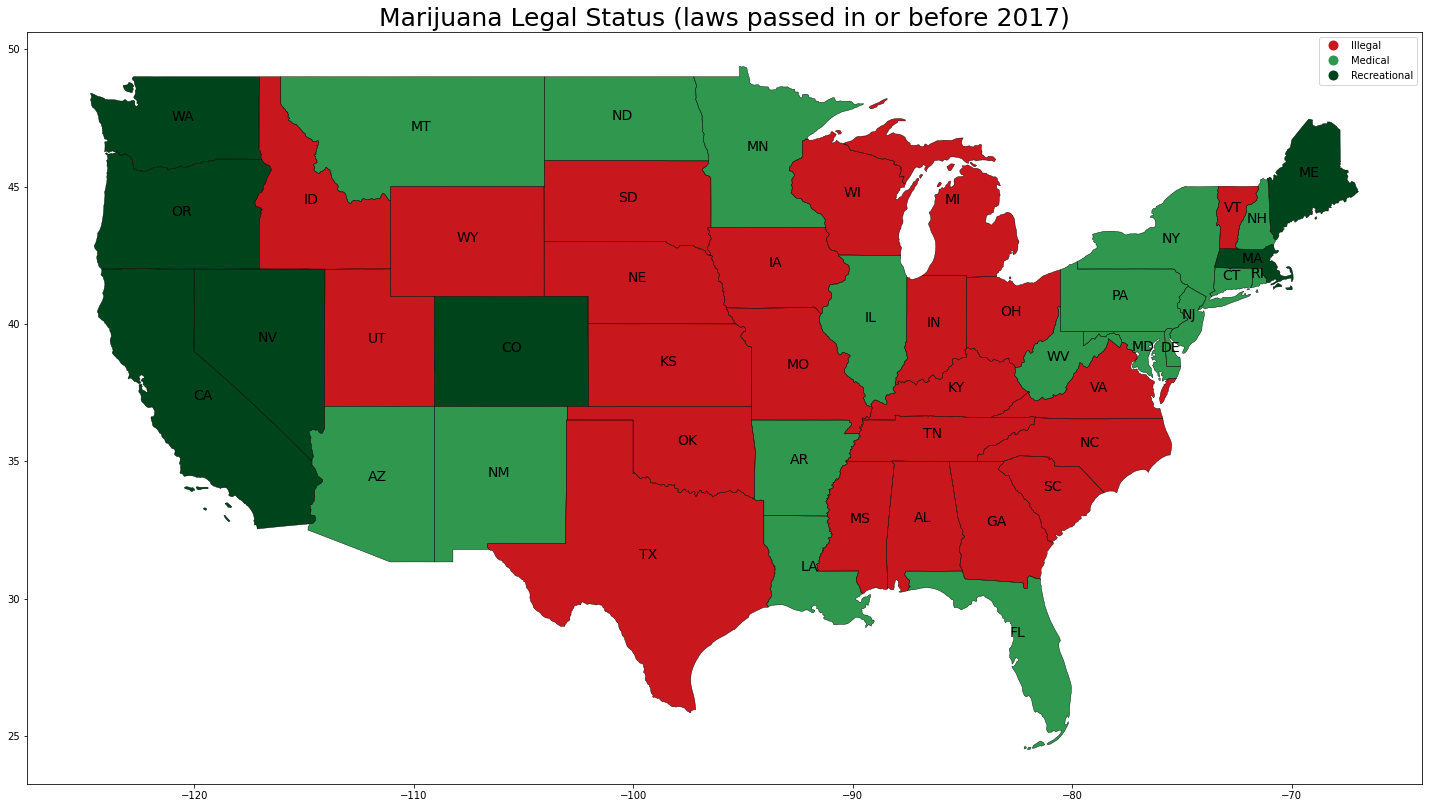

In [48]:
#
geo_state_laws=geo_merge.merge(state_laws, on='State')

#Custom color map
bottom = cm.get_cmap('Greens', 128)
top = cm.get_cmap("Reds",128)
newcolors = np.vstack((top(np.linspace(0.75, 1, 128)), bottom(np.linspace(0.7, 1, 128))))
newcmp = ListedColormap(newcolors, name='RGG')

#map of states and legal status as of the end of 2017
fig2, ax2 = plt.subplots(figsize=(25,15))
#add state abv to map
geo_state_laws.apply(lambda x: ax2.annotate(text=x.STUSPS, xy=x.geometry.centroid.coords[0], ha='center', fontsize=14),axis=1)
#make border of each state 0.4 wide black outline
geo_state_laws.boundary.plot(ax=ax2, color='Black', linewidth=.4)
#plot the map
geo_state_laws.plot(column='Legal Status', categorical=True, ax=ax2, legend=True,cmap=newcmp)
plt.title('Marijuana Legal Status (laws passed in or before 2017)',fontsize=25)
plt.show()

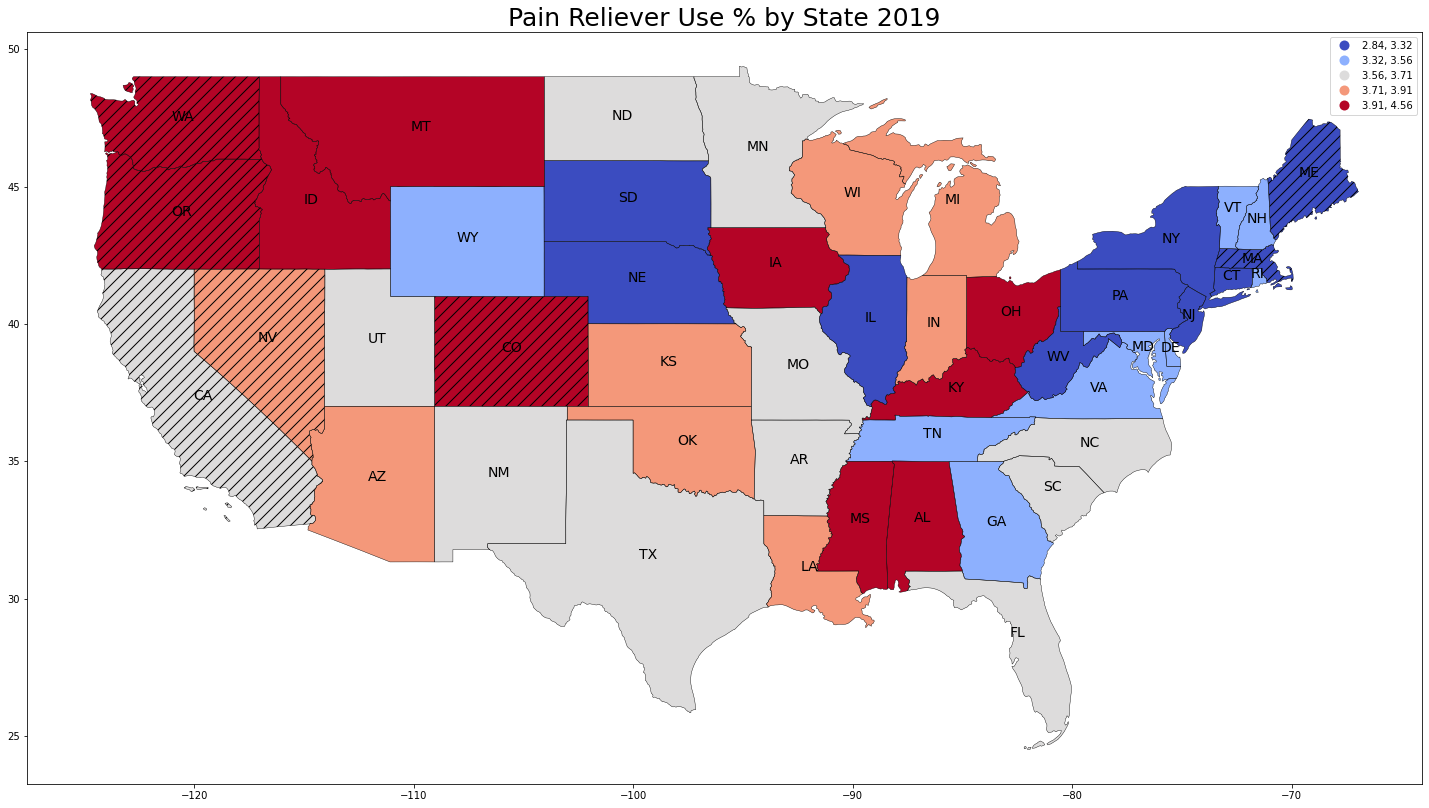

In [49]:
year2019 = percent_data[percent_data['Survey Year'] == 2019] #only 2019
year2019 = year2019[year2019.Age == '12+'] #ages 12+
geo_2019=geo_merge.merge(year2019, on='State') #merge geo data with 2019 data
geo_2019 =geo_2019.merge(state_laws, on='State') #add marijuana laws 

# plot figure
fig, ax = plt.subplots(figsize=(25,15))

#add state abv to map
geo_2019.apply(lambda x: ax.annotate(text=x.STUSPS, xy=x.geometry.centroid.coords[0], ha='center', fontsize=14),axis=1)
#make border of each state 0.4 wide black outline
geo_2019.boundary.plot(ax=ax, color='Black', linewidth=.4)

#create consistent bins for all 3 parts of the map
bins = mc.Quantiles(geo_2019['Past Year Misuse of Pain Relievers %'], k=5).bins
geo_2019[geo_2019["Legal Status"] == "Recreational"].plot(column='Past Year Misuse of Pain Relievers %', ax=ax, scheme='user_defined', classification_kwds={'bins':bins}, legend=True,cmap='coolwarm', hatch="//")
geo_2019[geo_2019["Legal Status"] == 'Illegal'].plot(column='Past Year Misuse of Pain Relievers %', ax=ax, scheme='user_defined', classification_kwds={'bins':bins}, legend=True,cmap='coolwarm')
geo_2019[geo_2019["Legal Status"] == 'Medical'].plot(column='Past Year Misuse of Pain Relievers %', ax=ax, scheme='user_defined', classification_kwds={'bins':bins}, legend=True,cmap='coolwarm')

plt.title('Pain Reliever Use % by State 2019',fontsize=25)
plt.show()

In [35]:
'''
#% use of pain relievers went down in every state regardless of legality
recreational2017 = recreational[recreational['Survey Year'] == 2017]
#recreational2018 = recreational[recreational['Survey Year'] == 2018]
recreational2019 = recreational[recreational['Survey Year'] == 2019]
print(recreational2017['Past Year Misuse of Pain Relievers %'].mean())
#print(recreational2018['Past Year Misuse of Pain Relievers %'].mean())
print(recreational2019['Past Year Misuse of Pain Relievers %'].mean())

illegal2017 = illegal[illegal['Survey Year'] == 2017]
#illegal2018 = illegal[illegal['Survey Year'] == 2018]
illegal2019 = illegal[illegal['Survey Year'] == 2019]
print(illegal2017['Past Year Misuse of Pain Relievers %'].mean())
#print(illegal2018['Past Year Misuse of Pain Relievers %'].mean())
print(illegal2019['Past Year Misuse of Pain Relievers %'].mean())

medical2017 = medical[medical['Survey Year'] == 2017]
#medical2018 = medical[medical['Survey Year'] == 2018]
medical2019 = medical[medical['Survey Year'] == 2019]
print(medical2017['Past Year Misuse of Pain Relievers %'].mean())
#print(medical2018['Past Year Misuse of Pain Relievers %'].mean())
print(medical2019['Past Year Misuse of Pain Relievers %'].mean())

print(stats.ttest_rel(medical2019['Past Year Misuse of Pain Relievers %'], medical2017['Past Year Misuse of Pain Relievers %']))
print(stats.ttest_rel(recreational2019['Past Year Misuse of Pain Relievers %'], recreational2017['Past Year Misuse of Pain Relievers %']))
print(stats.ttest_rel(illegal2019['Past Year Misuse of Pain Relievers %'], illegal2017['Past Year Misuse of Pain Relievers %']))

#medical states had the lowest t-statistic which means the difference between years had the most significance
#import math
#import statistics
#Using Cohen's d Measure
#NY_std = orderNY["statistics.height"].std() 
#Chi_std = orderChicago["statistics.height"].std()
#pool_std = math.sqrt((NY_std**2+Chi_std**2)/2)
#d = (orderNY["statistics.height"].mean()- orderChicago["statistics.height"].mean())/pool_std
#print(d)
'''

'\n#% use of pain relievers went down in every state regardless of legality\nrecreational2017 = recreational[recreational[\'Survey Year\'] == 2017]\n#recreational2018 = recreational[recreational[\'Survey Year\'] == 2018]\nrecreational2019 = recreational[recreational[\'Survey Year\'] == 2019]\nprint(recreational2017[\'Past Year Misuse of Pain Relievers %\'].mean())\n#print(recreational2018[\'Past Year Misuse of Pain Relievers %\'].mean())\nprint(recreational2019[\'Past Year Misuse of Pain Relievers %\'].mean())\n\nillegal2017 = illegal[illegal[\'Survey Year\'] == 2017]\n#illegal2018 = illegal[illegal[\'Survey Year\'] == 2018]\nillegal2019 = illegal[illegal[\'Survey Year\'] == 2019]\nprint(illegal2017[\'Past Year Misuse of Pain Relievers %\'].mean())\n#print(illegal2018[\'Past Year Misuse of Pain Relievers %\'].mean())\nprint(illegal2019[\'Past Year Misuse of Pain Relievers %\'].mean())\n\nmedical2017 = medical[medical[\'Survey Year\'] == 2017]\n#medical2018 = medical[medical[\'Survey Ye

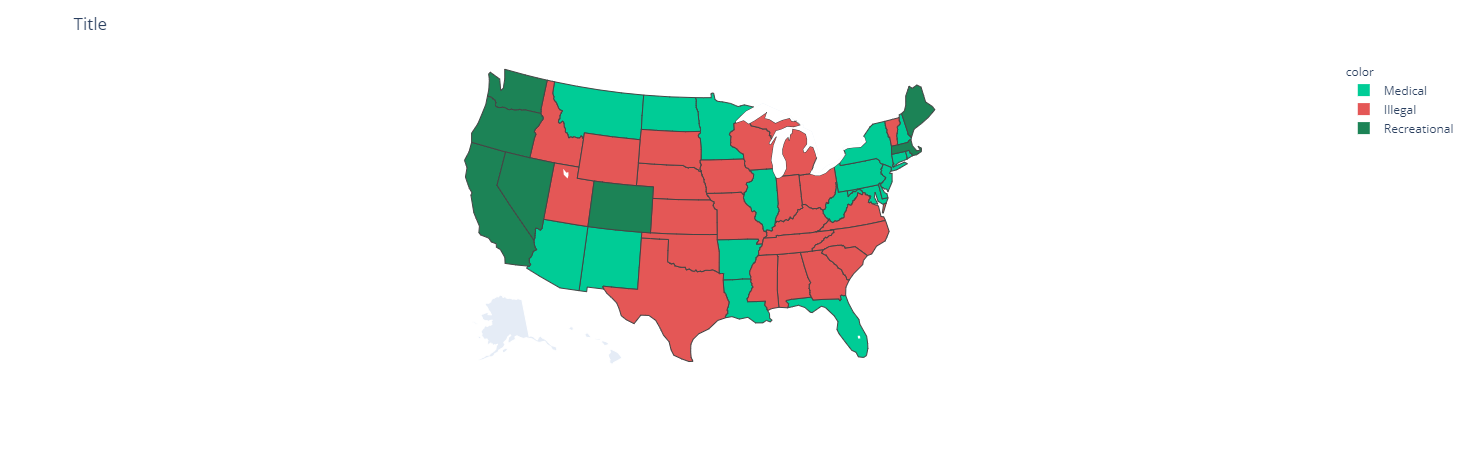

In [37]:
import plotly.express as px

fig = px.choropleth(locations=geo_state_laws["STUSPS"], locationmode='USA-states',
                    color=geo_state_laws["Legal Status"], # lifeExp is a column of gapminder
                    color_discrete_sequence=['#00CC96', '#E45756', '#1C8356'])

#fig = go.Figure(data=go.Choropleth(
#    locations=geo_state_laws['STUSPS'], # Spatial coordinates
#    z = geo_state_laws['Legal Status'], # Data to be color-coded
#    locationmode = 'USA-states', # set of locations match entries in `locations`
#    colorscale = 'Reds',
#    colorbar_title = "Millions USD",
#))

fig.update_layout(
    title_text = 'Title',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

In [38]:
geo_state_laws['Year Passed'] = geo_state_laws['Year Passed'].astype(str)

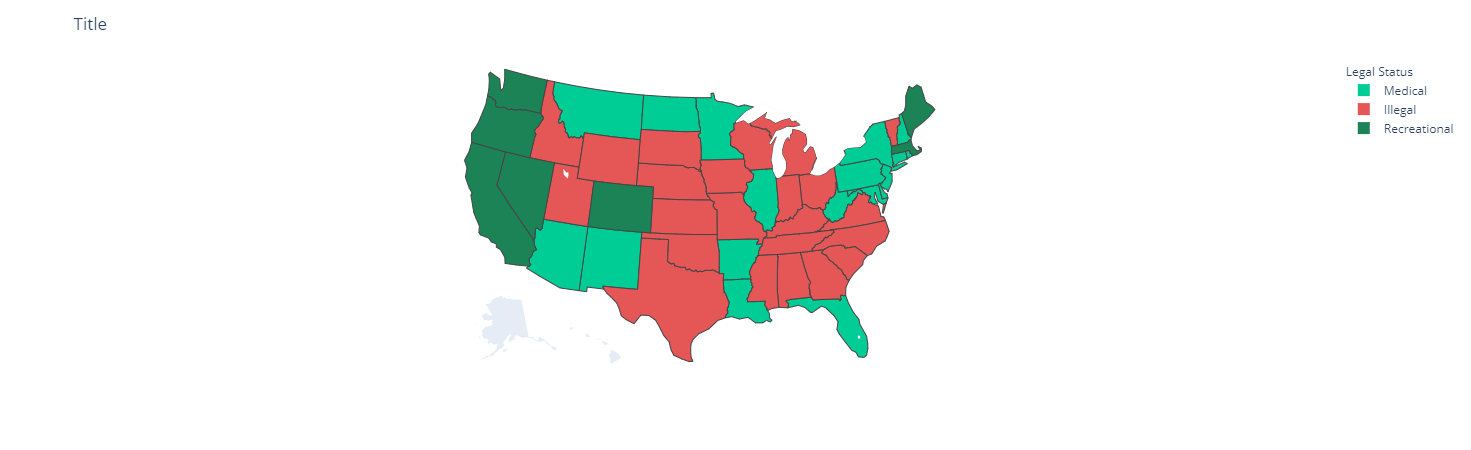

In [39]:
fig = px.choropleth(geo_state_laws, locations="STUSPS", locationmode='USA-states',
                    labels={'Year Passed':'Year Passed', 'STUSPS':'State', 'Legal Status':'Legal Status'},
                    color="Legal Status", # lifeExp is a column of gapminder
                    color_discrete_sequence=['#00CC96', '#E45756', '#1C8356'])

fig.update_layout(
    title_text = 'Title',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

### After this point I started working in the final file, pasting things into the messy file to try them out and save chunks of code

,Survey Year,Age,Past Month Illicit Drug Use %,Past Year Marijuana Use %,Past Month Marijuana Use %,Past Year Cocaine Use %,Past Month Alcohol Use %,Past Month Binge Alcohol Use %,Past Month Cigarette Use %,First Use of Marijuana %,...,Past Year Heroin Use %,Past Year Methamphetamine Use %,Past Year Misuse of Pain Relievers %,Illicit Drug Use Disorder %,Pain Reliever Use Disorder %,Alcohol Use Disorder %,Substance Use Disorder %,State,Legal Status,Year Passed


In [9]:
percent_data = percent_data.merge(state_laws, on='State') #add marijuana laws

#separate adults from percent_data, only want data for 18+ (prevent overlapping data)
percent_data_adults = percent_data[percent_data.Age == '18+'] #adults
#3 datasets for different legal status
illegal = percent_data_adults[percent_data_adults['Legal Status'] == 'Illegal']
recreational = percent_data_adults[percent_data_adults['Legal Status'] == 'Recreational']
medical = percent_data_adults[percent_data_adults['Legal Status'] == 'Medical']

In [10]:
#drop all NaNs only in the Past Year Misuse of Pain Relievers % column (if dropna all NaNs then relevant data would be lost)
medical_PR = medical.dropna(subset=['Past Year Misuse of Pain Relievers %']) 
print(stats.pearsonr(medical_PR['Past Year Misuse of Pain Relievers %'], medical_PR['Survey Year']))
recreational_PR = recreational.dropna(subset=['Past Year Misuse of Pain Relievers %']) 
print(stats.pearsonr(recreational_PR['Past Year Misuse of Pain Relievers %'], recreational_PR['Survey Year']))
illegal_PR = illegal.dropna(subset=['Past Year Misuse of Pain Relievers %']) 
print(stats.pearsonr(illegal_PR['Past Year Misuse of Pain Relievers %'], illegal_PR['Survey Year']))


(-0.6639572021923202, 6.245983576701697e-11)
(-0.5847098530625214, 0.000440714418993047)
(-0.6945875269892616, 1.6022964773779747e-14)


In [13]:
#Calculating Confidence Intervals
medical_PR_2016 = medical_PR[medical_PR['Survey Year'] == 2016]
medical_PR_2017 =  medical_PR[medical_PR['Survey Year'] == 2017]
medical_PR_2018 =  medical_PR[medical_PR['Survey Year'] == 2018]
medical_PR_2019 = medical_PR[medical_PR['Survey Year'] == 2019]
medical_PR_Years = [medical_PR_2016, medical_PR_2017, medical_PR_2018, medical_PR_2019]
y_upper_m = []
y_lower_m = []
for year in medical_PR_Years:
    ci = (stats.t.interval(alpha=0.95, df=len(year['Past Year Misuse of Pain Relievers %'])-1,
                 loc=np.mean(year['Past Year Misuse of Pain Relievers %']),
                 scale=stats.sem(year['Past Year Misuse of Pain Relievers %'])))
    y_lower_m.append(ci[0])
    y_upper_m.append(ci[1])    
medical_PR = medical_PR.groupby(['Survey Year']).mean().reset_index()
    

illegal_PR_2016 = illegal_PR[illegal_PR['Survey Year'] == 2016]
illegal_PR_2017 =  illegal_PR[illegal_PR['Survey Year'] == 2017]
illegal_PR_2018 =  illegal_PR[illegal_PR['Survey Year'] == 2018]
illegal_PR_2019 = illegal_PR[illegal_PR['Survey Year'] == 2019]
illegal_PR_Years = [illegal_PR_2016, illegal_PR_2017, illegal_PR_2018, illegal_PR_2019]
y_upper_i = []
y_lower_i = []
for year in illegal_PR_Years:
    ci = (stats.t.interval(alpha=0.95, df=len(year['Past Year Misuse of Pain Relievers %'])-1,
                 loc=np.mean(year['Past Year Misuse of Pain Relievers %']),
                 scale=stats.sem(year['Past Year Misuse of Pain Relievers %'])))
    y_lower_i.append(ci[0])
    y_upper_i.append(ci[1])   
illegal_PR = illegal_PR.groupby(['Survey Year']).mean().reset_index()

rec_PR_2016 = recreational_PR[recreational_PR['Survey Year'] == 2016]
rec_PR_2017 =  recreational_PR[recreational_PR['Survey Year'] == 2017]
rec_PR_2018 =  recreational_PR[recreational_PR['Survey Year'] == 2018]
rec_PR_2019 = recreational_PR[recreational_PR['Survey Year'] == 2019]
rec_PR_Years = [rec_PR_2016, rec_PR_2017, rec_PR_2018, rec_PR_2019]
y_upper_r = []
y_lower_r = []
for year in rec_PR_Years:
    ci = (stats.t.interval(alpha=0.95, df=len(year['Past Year Misuse of Pain Relievers %'])-1,
                 loc=np.mean(year['Past Year Misuse of Pain Relievers %']),
                 scale=stats.sem(year['Past Year Misuse of Pain Relievers %'])))
    y_lower_r.append(ci[0])
    y_upper_r.append(ci[1])   
recreational_PR = recreational_PR.groupby(['Survey Year']).mean().reset_index()

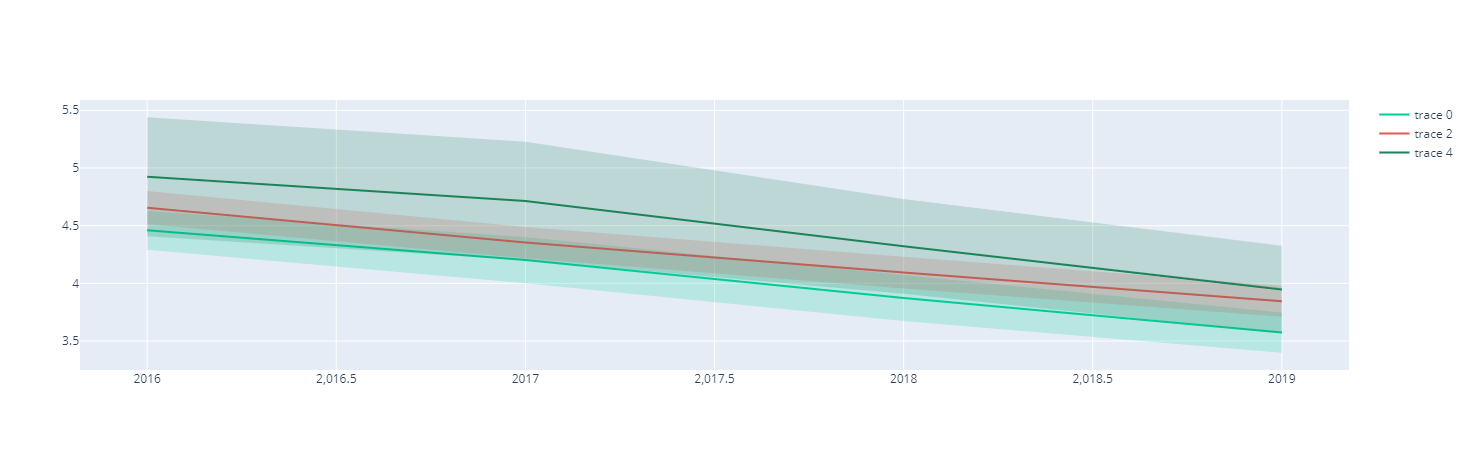

In [14]:
fig = go.Figure([
    go.Scatter(
        x=medical_PR['Survey Year'],
        y=medical_PR["Past Year Misuse of Pain Relievers %"],
        line=dict(color='rgb(0,204,150)'),
        mode='lines'
    ),
    go.Scatter(
        x=medical_PR['Survey Year'].to_list()+medical_PR['Survey Year'].to_list()[::-1], # x, then x reversed
        y=y_upper_m+y_lower_m[::-1], # upper, then lower reversed
        fill='toself',
        fillcolor='rgba(0,204,150,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        showlegend=False
    ),
    go.Scatter(
        x=illegal_PR['Survey Year'],
        y=illegal_PR["Past Year Misuse of Pain Relievers %"],
        line=dict(color='rgb(228,87,86)'),
        mode='lines'
    ),
    go.Scatter(
        x=illegal_PR['Survey Year'].to_list()+illegal_PR['Survey Year'].to_list()[::-1], # x, then x reversed
        y=y_upper_i+y_lower_i[::-1], # upper, then lower reversed
        fill='toself',
        fillcolor='rgba(228,87,86,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        showlegend=False
    ),
    go.Scatter(
        x=recreational_PR['Survey Year'],
        y=recreational_PR["Past Year Misuse of Pain Relievers %"],
        line=dict(color='rgb(28,131,86)'),
        mode='lines'
    ),
    go.Scatter(
        x=recreational_PR['Survey Year'].to_list()+recreational_PR['Survey Year'].to_list()[::-1], # x, then x reversed
        y=y_upper_r+y_lower_r[::-1], # upper, then lower reversed
        fill='toself',
        fillcolor='rgba(28,131,86,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        showlegend=False
    )
])
fig.show()

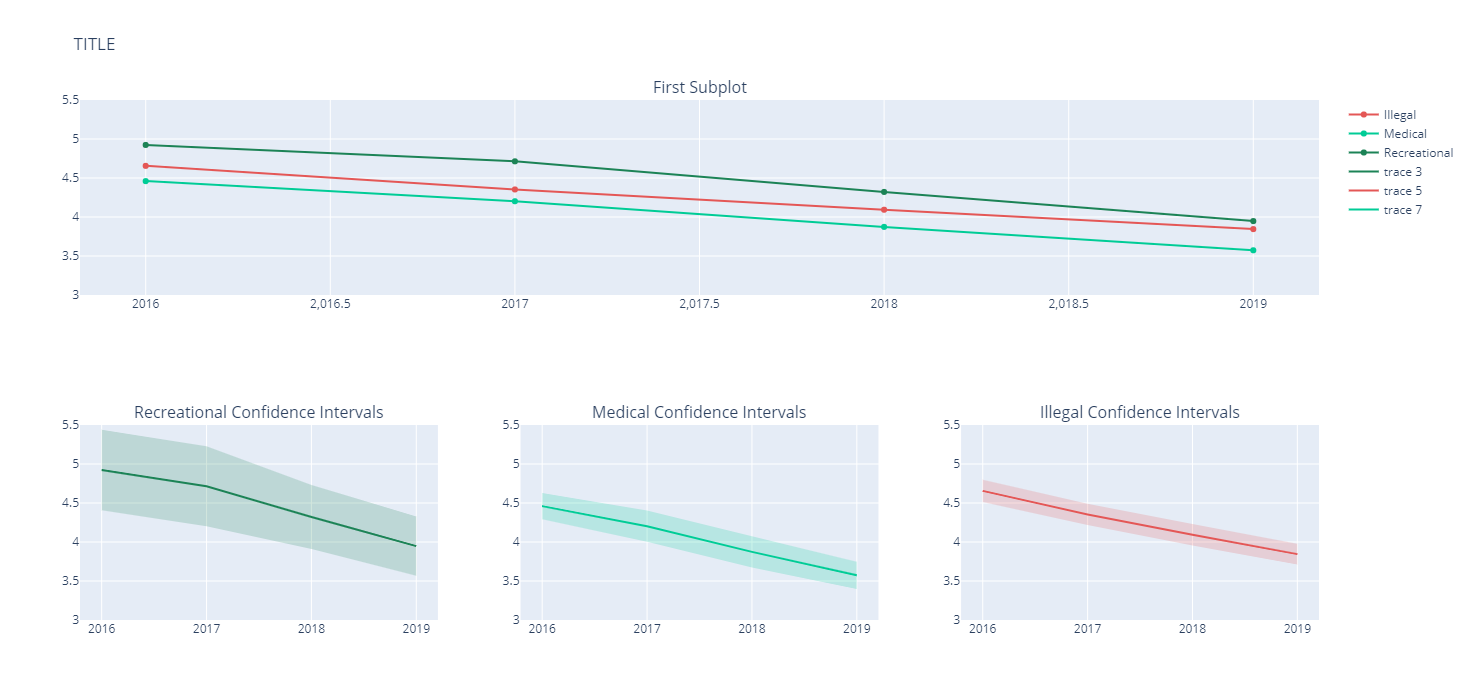

In [15]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=3, 
                    specs=[[{"colspan":3}, None, None],
                   [{}, {}, {}]],
                subplot_titles=("First Subplot","Recreational Confidence Intervals", "Medical Confidence Intervals", "Illegal Confidence Intervals"))

df = pd.pivot_table(percent_data_adults, values='Past Year Misuse of Pain Relievers %', index=['Survey Year'],columns='Legal Status', aggfunc=np.mean)

#top plot with all 3 lines
i = 0
colors = ['#E45756', '#00CC96', '#1C8356']
for col in df.columns:
    fig.add_trace(go.Scatter(x=df.index, y=df[col].values,
                             name = col,
                             mode = 'markers+lines',
                             line=dict(shape='linear', color=colors[i]),
                             connectgaps=True
                             )
                 )
    i+=1
    
#bottom left
fig.add_trace(
    go.Scatter(
        x=recreational_PR['Survey Year'],
        y=recreational_PR["Past Year Misuse of Pain Relievers %"],
        line=dict(color='rgb(28,131,86)'),
        mode='lines'
    ), row=2, col=1
)
fig.add_trace(
    go.Scatter(
        x=recreational_PR['Survey Year'].to_list()+recreational_PR['Survey Year'].to_list()[::-1], # x, then x reversed
        y=y_upper_r+y_lower_r[::-1], # upper, then lower reversed
        fill='toself',
        fillcolor='rgba(28,131,86,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        showlegend=False
    ), row=2, col=1
)


#bottom middle
fig.add_trace(
    go.Scatter(
        x=illegal_PR['Survey Year'],
        y=illegal_PR["Past Year Misuse of Pain Relievers %"],
        line=dict(color='rgb(228,87,86)'),
        mode='lines'
    ), row=2, col=3
)
fig.add_trace(
    go.Scatter(
        x=illegal_PR['Survey Year'].to_list()+illegal_PR['Survey Year'].to_list()[::-1], # x, then x reversed
        y=y_upper_i+y_lower_i[::-1], # upper, then lower reversed
        fill='toself',
        fillcolor='rgba(228,87,86,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        showlegend=False
    ), row=2, col=3
)

#bottom right
fig.add_trace(
    go.Scatter(
        x=medical_PR['Survey Year'],
        y=medical_PR["Past Year Misuse of Pain Relievers %"],
        line=dict(color='rgb(0,204,150)'),
        mode='lines'
    ), row=2, col=2
)
fig.add_trace(
    go.Scatter(
        x=medical_PR['Survey Year'].to_list()+medical_PR['Survey Year'].to_list()[::-1], # x, then x reversed
        y=y_upper_m+y_lower_m[::-1], # upper, then lower reversed
        fill='toself',
        fillcolor='rgba(0,204,150,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        showlegend=False
    ), row=2, col=2
)

fig.update_yaxes(title_text="Percent of Population", range=[40, 80], row=1, col=2)
fig.update_yaxes(range=[3, 5.5], row=1, col=1)
fig.update_yaxes(range=[3, 5.5], row=2, col=1)
fig.update_yaxes(range=[3, 5.5], row=2, col=2)
fig.update_yaxes(range=[3, 5.5], row=2, col=3)
fig.update_layout(title_text="TITLE", height=700)

fig.show()

In [16]:
def calc_CI(data):
    data_2016 = data[data['Survey Year'] == 2016]
    data_2017 =  data[data['Survey Year'] == 2017]
    data_2018 =  data[data['Survey Year'] == 2018]
    data_2019 = data[data['Survey Year'] == 2019]
    data_Years = [data_2016,data_2017,data_2018,data_2019]
    upper = []
    lower = []
    for year in data_Years:
        ci = (stats.t.interval(alpha=0.95, df=len(year['Past Year Misuse of Pain Relievers %'])-1,
                     loc=np.mean(year['Past Year Misuse of Pain Relievers %']),
                     scale=stats.sem(year['Past Year Misuse of Pain Relievers %'])))
        lower.append(ci[0])
        upper.append(ci[1])   
    #data = data.groupby(['Survey Year']).mean().reset_index()
    return upper, lower

y_upper_i, y_lower_i = calc_CI(illegal_PR)
y_upper_m, y_lower_m = calc_CI(medical_PR)
y_upper_r, y_lower_r = calc_CI(recreational_PR)

c:\users\ben\documents\udel\cisc367\venv\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning:

Degrees of freedom <= 0 for slice

c:\users\ben\documents\udel\cisc367\venv\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\ben\documents\udel\cisc367\venv\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning:

Degrees of freedom <= 0 for slice

c:\users\ben\documents\udel\cisc367\venv\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\ben\documents\udel\cisc367\venv\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning:

Degrees of freedom <= 0 for slice

c:\users\ben\documents\udel\cisc367\venv\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning:

invalid value encountered in double_scalars



In [23]:
df = df.reset_index()

In [25]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=3, 
                    specs=[[{"colspan":3}, None, None],
                   [{}, {}, {}]],
                subplot_titles=("First Subplot","Recreational Confidence Intervals", "Medical Confidence Intervals", "Illegal Confidence Intervals"))

#top plot with all 3 lines
i = 0
colors = ['#E45756', '#00CC96', '#1C8356']
for col in df.columns:
    m, b = np.polyfit(df['Survey Year'], data_test_I['Past Year Marijuana Use %'], 1)
    fig.add_trace(go.Scatter(x=df.index, y=df[col].values,
                             name = col,
                             mode = 'markers+lines',
                             line=dict(shape='linear', color=colors[i]),
                             connectgaps=True
                             )
                 )
    i+=1


fig.update_layout(title_text="TITLE", height=700)
fig.show()

IndexError: list index out of range

In [1]:
mi, bi = np.polyfit(data_test_I['Survey Year'], data_test_I['Past Year Marijuana Use %'], 1)
mr, br = np.polyfit(data_test_R['Survey Year'], data_test_R['Past Year Marijuana Use %'], 1)
mm, bm = np.polyfit(data_test_M['Survey Year'], data_test_M['Past Year Marijuana Use %'], 1)
plt.plot(data_test_I['Survey Year'], data_test_I['Past Year Marijuana Use %'], 'o')
plt.plot(data_test_I['Survey Year'], mi*data_test_I['Survey Year'] + bi)

plt.plot(data_test_R['Survey Year'], data_test_R['Past Year Marijuana Use %'], 'o')
plt.plot(data_test_R['Survey Year'], mr*data_test_R['Survey Year'] + br)

plt.plot(data_test_M['Survey Year'], data_test_M['Past Year Marijuana Use %'], 'o')
plt.plot(data_test_M['Survey Year'], mm*data_test_M['Survey Year'] + bm)

NameError: name 'np' is not defined

In [34]:
def calc_CI(data, question):
    data_2013 = data[data['Survey Year'] == 2013]
    data_2014 = data[data['Survey Year'] == 2014]
    data_2015 = data[data['Survey Year'] == 2015]
    data_2016 = data[data['Survey Year'] == 2016]
    data_2017 =  data[data['Survey Year'] == 2017]
    data_2018 =  data[data['Survey Year'] == 2018]
    data_2019 = data[data['Survey Year'] == 2019]
    data_Years = [data_2013,data_2014,data_2015,data_2016,data_2017,data_2018,data_2019]
    upper = []
    lower = []
    for year in data_Years:
        ci = (stats.t.interval(alpha=0.95, df=len(year[question])-1,
                     loc=np.mean(year[question]),
                     scale=stats.sem(year[question])))
        lower.append(ci[0])
        upper.append(ci[1])
    return upper, lower

In [31]:
from plotly.subplots import make_subplots

def add_plot(data, row, col, color, fig, upper, lower, ci_color, question):
    fig.add_trace(
        go.Scatter(
            x=data['Survey Year'],
            y=data[question],
            line=dict(color=color),
            showlegend=False,
            name='',
            mode='lines'
        ), row=row, col=col
    )
    fig.add_trace(
        go.Scatter(
            x=data['Survey Year'].to_list()+data['Survey Year'].to_list()[::-1], # x, then x reversed
            y=upper+lower[::-1], # upper, then lower reversed
            fill='toself',
            fillcolor=ci_color,
            line=dict(color='rgba(255,255,255,0)'),
            hoverinfo="skip",
            showlegend=False
        ), row=row, col=col
    )

c:\users\ben\documents\udel\cisc367\venv\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning:

Degrees of freedom <= 0 for slice

c:\users\ben\documents\udel\cisc367\venv\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\ben\documents\udel\cisc367\venv\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning:

Degrees of freedom <= 0 for slice

c:\users\ben\documents\udel\cisc367\venv\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\ben\documents\udel\cisc367\venv\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning:

Degrees of freedom <= 0 for slice

c:\users\ben\documents\udel\cisc367\venv\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning:

invalid value encountered in double_scalars



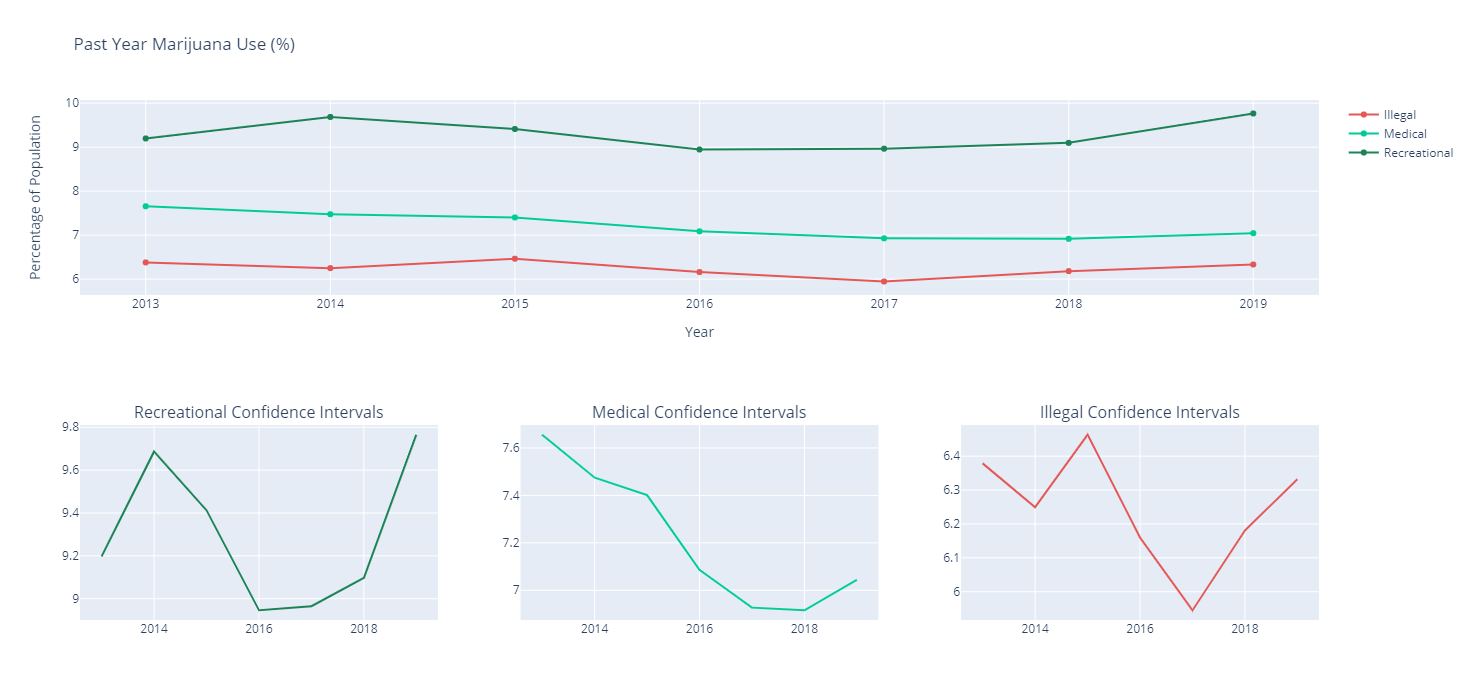

In [33]:
question = "Past Year Cocaine Use %"

y_upper_i, y_lower_i = calc_CI(data_test_I, question)
y_upper_m, y_lower_m = calc_CI(data_test_M, question)
y_upper_r, y_lower_r = calc_CI(data_test_R, question)

data_test_M = data_test_M.groupby(['Survey Year']).mean().reset_index()
data_test_I = data_test_I.groupby(['Survey Year']).mean().reset_index()
data_test_R = data_test_R.groupby(['Survey Year']).mean().reset_index()

df = pd.pivot_table(data_teens, values=question index=['Survey Year'],columns='Legal Status', aggfunc=np.mean)

fig = make_subplots(rows=2, cols=3, 
                    specs=[[{"colspan":3}, None, None],
                   [{}, {}, {}]],
                subplot_titles=("","Recreational Confidence Intervals", "Medical Confidence Intervals", "Illegal Confidence Intervals"))

#top plot with all 3 lines
i = -1
colors = ['#E45756', '#00CC96', '#1C8356']
for col in df.columns:
    i += 1
    fig.add_trace(go.Scatter(x=df.index, y=df[col].values,
                             name = col,
                             mode = 'markers+lines',
                             line=dict(shape='linear', color=colors[i]),
                             connectgaps=True
                             )
                 )

add_plot(data_test_I, 2, 3, 'rgb(228,87,86)', fig, y_upper_i, y_lower_i, 'rgba(228,87,86,0.2)', question)
add_plot(data_test_M, 2, 2, 'rgb(0,204,150)', fig, y_upper_m, y_lower_m, 'rgba(0,204,150,0.2)', question)
add_plot(data_test_R, 2, 1, 'rgb(28,131,86)', fig, y_upper_r, y_lower_r, 'rgba(28,131,86,0.2)', question)
fig.update_layout(title_text="Past Year Marijuana Use (%)", height=700)
fig.update_layout(xaxis_title="Year", yaxis_title = "Percentage of Population")
fig.show()

<a id='prDR'></a>
### Rates of Decline 
Quantifying the rate of decline.

The visualization above shows that states with differing cannabis legal status have all declined between 2016 and 2019. While all 3 categories experienced declines in past year misuse of pain relievers, the rate of declines differ between the states. 

In [ ]:
print((df['Illegal'][2019] - df['Illegal'][2016])/df['Illegal'][2016])
print((df['Medical'][2019] - df['Medical'][2016])/df['Medical'][2016])
print((df['Recreational'][2019] - df['Recreational'][2016])/df['Recreational'][2016])

<a id='prhist'></a>
### Histogram

The data_states set includes all of the age categories listed in the NSDUH survey. These age groups include 12+, 12-17, 18+, 18-25 and 26+. Due to the age groupings, some data overlaps. For example, data in the 12-17 group is included in the 12+ group. The histogram below displays data from all people without overlaps, or all the data in the 12+ age group.

In [ ]:
#take the dataframe of all people surveyed, 12+ age (prevent overlapping data)
data_12up = data_states[data_states['Age'] == '12+']
#average between all the survey years
data_12up = data_12up.groupby(['State']).mean().drop(['Survey Year'], axis=1)
data_12up['Past Year Misuse of Pain Relievers (total)'].iplot(kind='hist', xTitle='Estimated Number of People in Thousands', yTitle='Number of States', title='Histogram of Past Year Misuse of Pain Relievers (2016-2019 average)', color='Green')

The histogram above shows that more than half of the US states estimate between 0 and 200 thousand people misuse pain relievers. The shape of this histogram is heavily skewed right, which means very few states have high numbers. In fact, only 6 states estimate over 400 thousand people misuse pain relievers. 